# Titanic - Machine Learning from Disaster

Reference: Will Cukierski. Titanic - Machine Learning from Disaster. https://kaggle.com/competitions/titanic, 2012. Kaggle.

This is a practice for Classification model

In [17]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

In [18]:
df_train = pd.read_csv('~/Desktop/train.csv').drop(['PassengerId','Name'], axis=1)
Id = pd.read_csv('~/Desktop/test.csv')['PassengerId']
df_test = pd.read_csv('~/Desktop/test.csv').drop(['PassengerId','Name'], axis=1)

## Handle Missing Values

In [19]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
df_train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [21]:
# Drop Cabin due to large volumn of missing values
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

# Drop Ticket as it Pclass already provided class info
df_train.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

In [22]:
# Fill Age missing value with its mean

age_mean = np.mean(df_train['Age'])
df_train['Age'] = df_train['Age'].fillna(age_mean)
df_test['Age'] = df_test['Age'].fillna(age_mean)

In [23]:
# Fill Embarked missing value with its mode

embarked_mode = df_train['Embarked'].mode()[0]
df_train['Embarked'] = df_train['Embarked'].fillna(embarked_mode)
df_test['Embarked'] = df_test['Embarked'].fillna(embarked_mode)

In [24]:
df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# EDA 

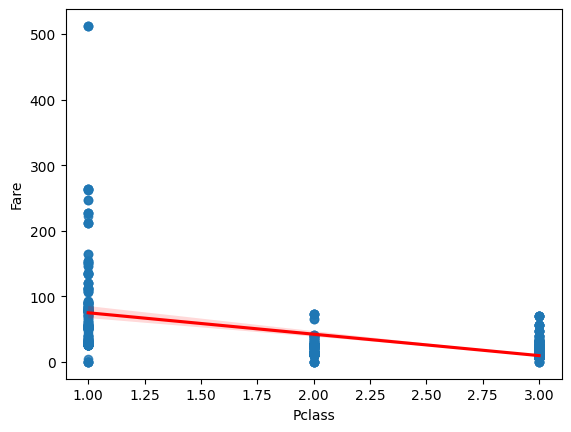

In [25]:
# relationship between passenger class and fare 
sns.regplot(data=df_train, x='Pclass', y='Fare', line_kws={'color':'r'})
plt.show()

In [26]:
df_train.groupby('Pclass').mean(numeric_only=True)

,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,
1,0.629630,37.048118,0.416667,0.356481,84.154687
2,0.472826,29.866958,0.402174,0.380435,20.662183
3,0.242363,26.403259,0.615071,0.393075,13.675550


Since the fare amount correlates with passenger class, one of them should be dropped. We should conduct an A/B test to see
dropping which one would result in a better model

In [27]:
df_train.drop('Fare', axis=1, inplace=True)
df_test.drop('Fare', axis=1, inplace=True)

## Dummy Variables

In [28]:
dummy_col = ['Pclass', 'Sex', 'Embarked']

from sklearn.preprocessing import OneHotEncoder

dummy_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

df_train_dummy = dummy_encoder.fit_transform(df_train[dummy_col]).toarray()
df_test_dummy = dummy_encoder.transform(df_test[dummy_col]).toarray()

df_train = pd.DataFrame(df_train_dummy, columns=dummy_encoder.get_feature_names_out()).join(df_train[['Age','SibSp', 'Parch', 'Survived']])
df_test = pd.DataFrame(df_test_dummy, columns=dummy_encoder.get_feature_names_out()).join(df_test[['Age','SibSp', 'Parch']])

## Feature Scaling

In [29]:
scaling_col = ['Age', 'SibSp', 'Parch']

from sklearn.preprocessing import StandardScaler

ss_scaler = StandardScaler().set_output(transform = 'pandas')

df_train[scaling_col] = ss_scaler.fit_transform(df_train[scaling_col])
df_test[scaling_col] = ss_scaler.fit_transform(df_test[scaling_col])

## Model Fitting

### 1. Logistic Regression

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

lr_model = LogisticRegressionCV(Cs = np.logspace(-4,4,20),
                                cv = 5,
                                penalty='l2',
                                solver='liblinear',
                                scoring='accuracy',
                                max_iter=500)
lr_model = lr_model.fit(X_train, y_train)
print(f"Best C: {lr_model.C_[0]}")

y_pred = lr_model.predict(X_test)
print(f'Accuracy for logistic regression is: {accuracy_score(y_test, y_pred)}')


Best C: 29.763514416313132
Accuracy for logistic regression is: 0.8156424581005587


### 2. LDA

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

lda = LinearDiscriminantAnalysis()

lda = lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

print(f'Accuracy for Linear Discriminant Analysis is: {accuracy_score(y_test, y_pred)}')

Accuracy for Linear Discriminant Analysis is: 0.8100558659217877


### 3. KNN

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

param_grid = {
    'n_neighbors': np.arange(1, 21),
    'weights': ["uniform", "distance"],
    'metric': ["euclidean", "manhattan", "minkowski"]
}


grid_search = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid= param_grid,
    cv = 5,
    scoring= 'accuracy',
    n_jobs= -1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

knn_model = grid_search.best_estimator_
y_pred = knn_model.predict(X_test)
print(f'Accuracy for KNN is: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Accuracy for KNN is: 0.8100558659217877
